# Crisis Watch (CW)

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("CW.csv").convert_dtypes()

### Rows and columns

In [3]:
rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 58725, Columns: 7


In [4]:
df['date'] = pd.to_datetime(df['yearmon'], errors='coerce').dt.date
df = df.convert_dtypes()
df = df.set_index(['date']).sort_index()
df = df.drop(columns=['yearmon'])

### Missing Values 

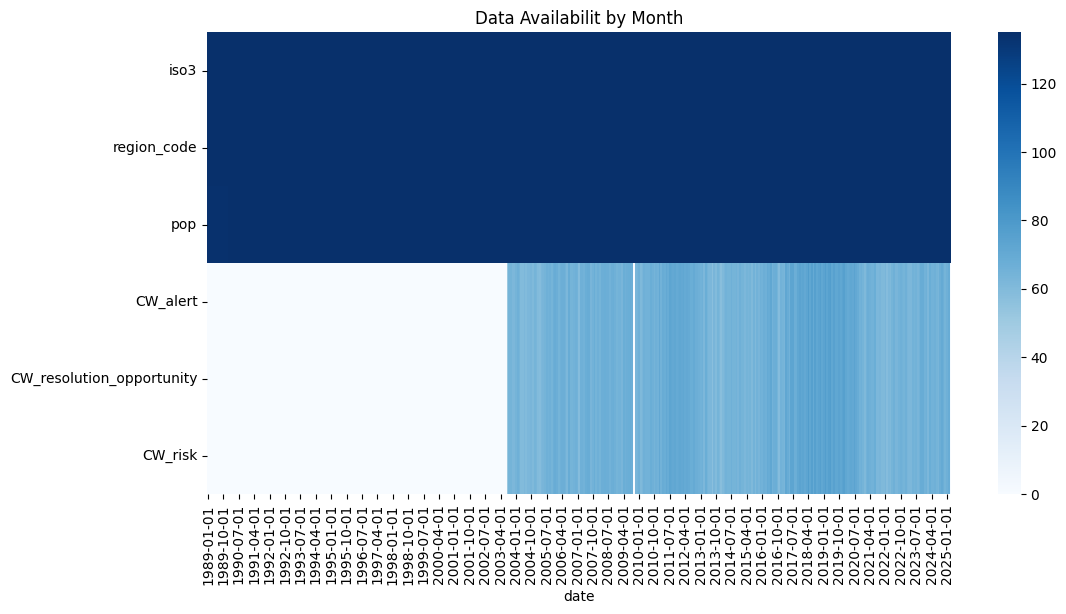

In [5]:
missing_by_month = df.groupby('date').count()
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_month.astype(float).T, cmap='Blues')
plt.title('Data Availabilit by Month')
plt.show()

### Sample data features 

In [6]:
df.tail().T

date,2025-03-01,2025-03-01,2025-03-01,2025-03-01,2025-03-01
iso3,BLZ,TUV,ZMB,TUN,ZWE
region_code,LAC,EAP,SSA,MNA,SSA
pop,411106.0,9816.0,20723965.0,12200431.0,16340822.0
CW_alert,<NA>,<NA>,<NA>,<NA>,<NA>
CW_resolution_opportunity,<NA>,<NA>,<NA>,<NA>,<NA>
CW_risk,<NA>,<NA>,<NA>,<NA>,<NA>


### Data structure, data types and non-null counts

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58725 entries, 1989-01-01 to 2025-03-01
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   iso3                       58725 non-null  string 
 1   region_code                58725 non-null  string 
 2   pop                        58713 non-null  Float64
 3   CW_alert                   17116 non-null  Int64  
 4   CW_resolution_opportunity  17116 non-null  Int64  
 5   CW_risk                    17116 non-null  Int64  
dtypes: Float64(1), Int64(3), string(2)
memory usage: 5.4+ MB


### Descriptive statistics of categorial columns

In [8]:
df.describe(include='string').T

,count,unique,top,freq
iso3,58725,135,AFG,435
region_code,58725,6,SSA,20445


### Descriptive statistics of numerical columns

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pop,58713.0,41259533.486332,153319719.021372,8662.0,2108617.0,8303151.0,25698326.0,1438069596.0
CW_alert,17116.0,0.037275,0.189441,0.0,0.0,0.0,0.0,1.0
CW_resolution_opportunity,17116.0,0.008939,0.094126,0.0,0.0,0.0,0.0,1.0
CW_risk,17116.0,0.103587,0.370023,-1.0,0.0,0.0,0.0,1.0


### Details of missing values 

In [10]:
total_rows = len(df)
missing_count = df.isnull().sum()
missing_percent = (missing_count / total_rows * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_count, 'Missing Percentage (%)': missing_percent})
missing_df = missing_df.sort_values(by='Missing Percentage (%)', ascending=False)
missing_df

,Missing Count,Missing Percentage (%)
CW_resolution_opportunity,41609,70.85
CW_alert,41609,70.85
CW_risk,41609,70.85
pop,12,0.02
region_code,0,0.00
iso3,0,0.00


In [11]:
columns = missing_df[missing_df['Missing Percentage (%)'] < 80].index
df = df[columns]

numeric_df = df.select_dtypes(include=['number']).dropna()


In [12]:
missing_by_iso3 = df.groupby('iso3').count()
missing_by_month = df.groupby('date').count()

### Correlation Matrix

In [13]:
#Correlation Matrix
correlation_matrix_df = numeric_df.corr(method='pearson')

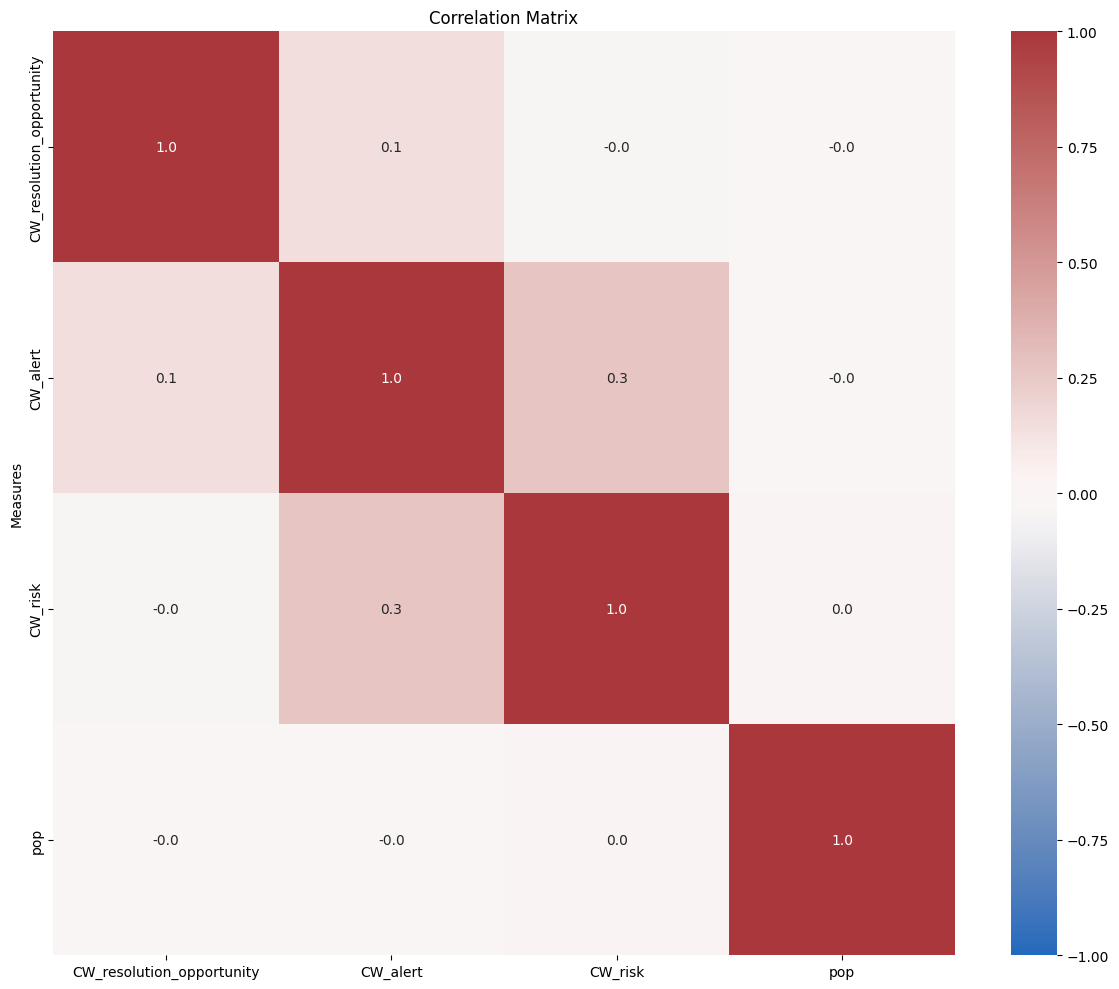

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.ylabel('Measures')
plt.tight_layout()
plt.show()


### Principal Component Analysis 

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)
pca = PCA(n_components=0.75)
X_pca = pca.fit_transform(X_scaled)
n_components = X_pca.shape[1]
print(f"Number of components retained: {n_components}")
columns = [f'PC{i+1}' for i in range(n_components)]
print(f"Column names for PCA components: {columns}")

Number of components retained: 3
Column names for PCA components: ['PC1', 'PC2', 'PC3']


In [16]:
pca_df = pd.DataFrame(X_pca, index=numeric_df.index, columns=columns)
pca_correlation_matrix_df = pca_df.corr(method='pearson')

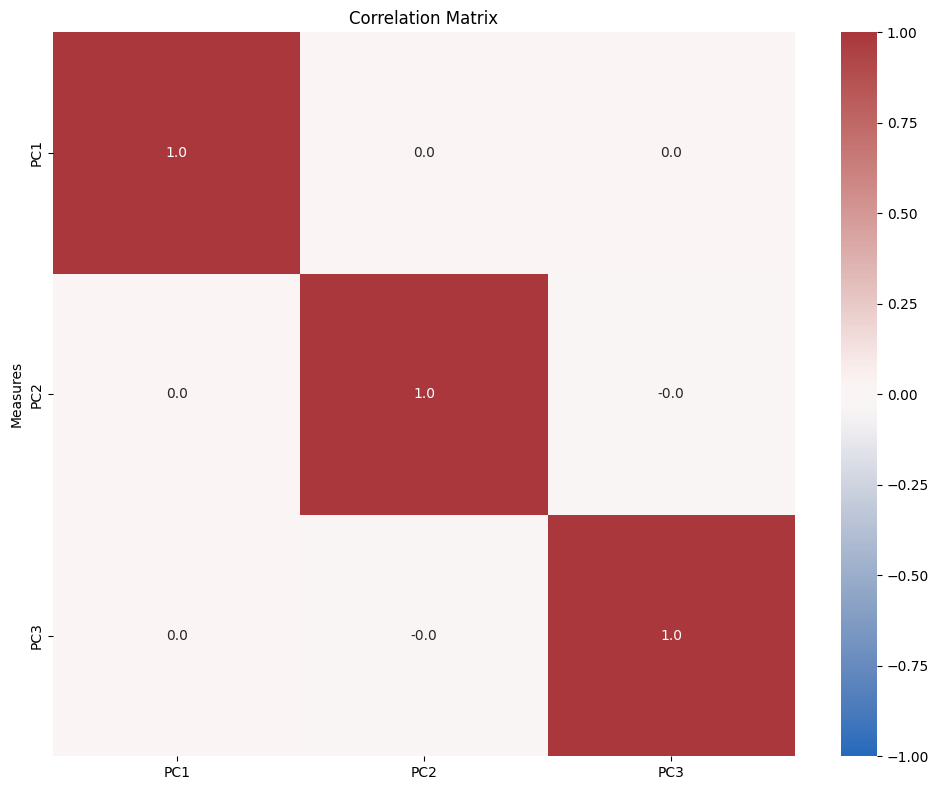

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(pca_correlation_matrix_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.ylabel('Measures')
plt.tight_layout()
plt.show()

### Explained Variance per component 

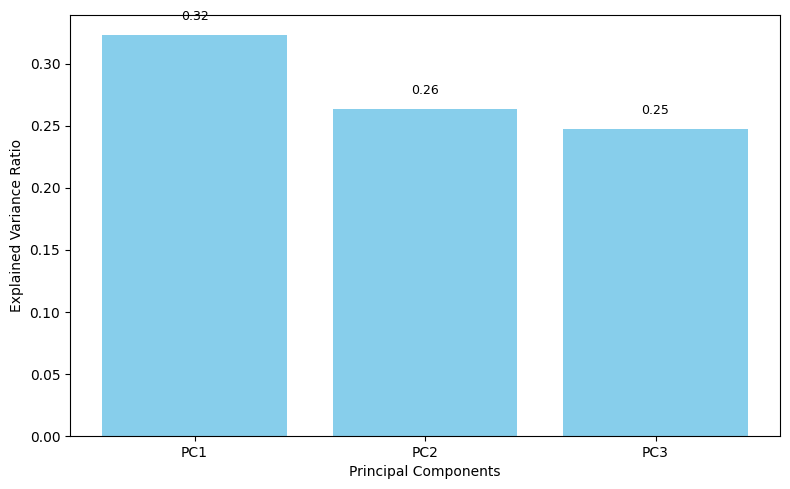

In [18]:
# Get explained variance ratios
explained_variance = pca.explained_variance_ratio_
components = np.arange(1, len(explained_variance) + 1)
labels = [f'PC{i}' for i in components]

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(x=components, height=explained_variance, tick_label=labels, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
# plt.title('Explained Variance by Principal Component')
plt.tight_layout()
plt.show()

### Cumulative Variance

Cumulative explained variance at component 2: 0.5863


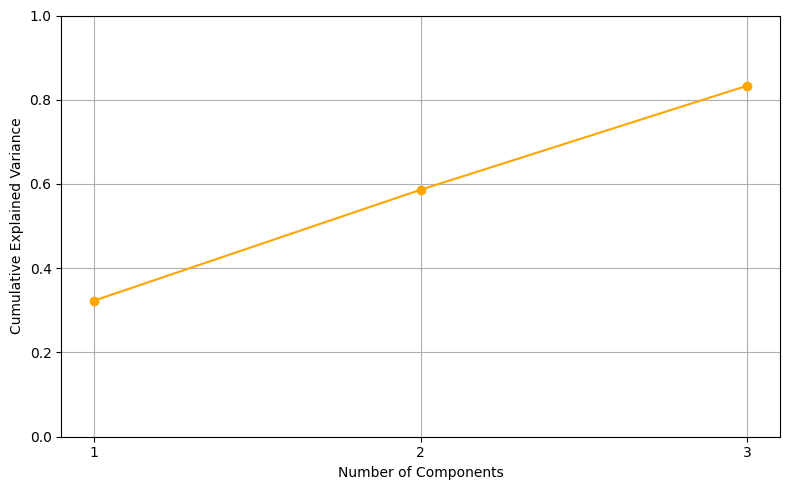

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `pca` has already been fitted
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Specify the component number (e.g., n = 4)
n = 2 # Change this to your desired component index
if n <= len(cumulative_variance):
    print(f"Cumulative explained variance at component {n}: {cumulative_variance[n-1]:.4f}")
else:
    print(f"Component {n} exceeds the total number of components ({len(cumulative_variance)}).")

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(1, len(cumulative_variance) + 1, step=1))
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


### PCA Loadings

In [20]:
feature_names = numeric_df.columns
components = pca.components_
loadings_df = pd.DataFrame(components.T, index=feature_names, columns=[f'PC{i+1}' for i in range(components.shape[0])])

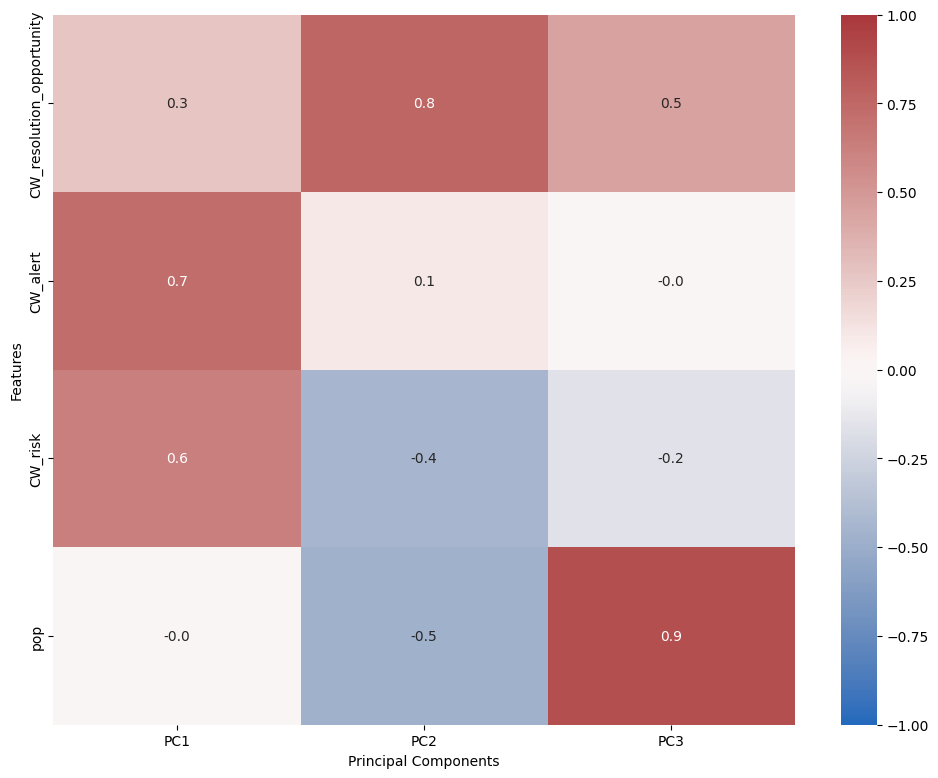

In [21]:
# create heatmap from loadings_df using sns
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
# plt.title('PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Physical Interpretation

### PC1- mainly indicates CW alert and CW risk. A “Risk Dashboard” summarizing real-time alerts and persistent systemic vulnerabilities, useful for monitoring when and where action is urgently needed.

### PC2- indicates resolution oppurtunity. A “Solution Space Index” — highlighting areas with high potential for intervention, reform, or recovery.